# Theory
We are going to attempt to use `scipy`'s `Rotation` object to change the acceleration, using the gyroscope values as row vectors.

# Imports

In [83]:
import os
import sys
import math

import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm_notebook as tqdm
from scipy.spatial.transform import Rotation as R

# Setup

In [49]:
tqdm.pandas()

D:\Users\liong\Anaconda3\lib\site-packages\tqdm\std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


# Navigate to data directory

In [11]:
def get_directory(address, show=True):
    """
    Get contents of a directory.
    
    Param:
        address: str
        show: boolean: if True, prints contents with indexing
    Return:
        directory: str[]: contents of directory
    """
    directory = os.listdir(address)
    
    # Print out contents
    if show:
        for ix, v in enumerate(directory):
            print(str(ix) + '. ' + v)
    
    return directory

address = '\\'.join(os.getcwd().split(
    '\\')[:-2]) + '\\Data' + '\\Patient001-2019-12-05' + '\\ftap-forearm' + '\\'

directory = get_directory(address)

0. ftap-lvl0-forearm_S2_2019-12-05T09.55.32.037_C49948A1895C_Accelerometer_1.4.5.csv
1. ftap-lvl0-forearm_S2_2019-12-05T09.55.32.037_C49948A1895C_Gyroscope_1.4.5.csv
2. ftap-lvl1-forearm_S2_2019-12-10T14.18.34.621_C49948A1895C_Accelerometer_1.4.5.csv
3. ftap-lvl1-forearm_S2_2019-12-10T14.18.34.621_C49948A1895C_Gyroscope_1.4.5.csv
4. ftap-lvl2-forearm _S2_2019-12-18T11.44.32.751_C49948A1895C_Accelerometer_1.4.5.csv
5. ftap-lvl2-forearm _S2_2019-12-18T11.44.32.751_C49948A1895C_Gyroscope_1.4.5.csv
6. ftap-lvl3-forearm_S2_2019-12-18T11.51.23.290_C49948A1895C_Accelerometer_1.4.5.csv
7. ftap-lvl3-forearm_S2_2019-12-18T11.51.23.290_C49948A1895C_Gyroscope_1.4.5.csv
8. ftap-lvl4-forearm_S2_2019-12-18T11.57.37.574_C49948A1895C_Accelerometer_1.4.5.csv
9. ftap-lvl4-forearm_S2_2019-12-18T11.57.37.574_C49948A1895C_Gyroscope_1.4.5.csv


# Selecting data
We select the first data, which is the accelerometer and gyroscope data associated with finger tap, level 0.

In [12]:
# Selecting index of accelerometer data
index = 0

In [13]:
# Asserts to define conditions of 'index'
assert index >= 0, "Index is negative"
assert index + 1 < len(directory), "Index is out of bounds"

In [35]:
# Parse into dictionary
"""
Data structure:
d: {
    'a' or 'g': {}: For accelerometer/gyroscope respectively
        {
            'name': str: filename
            'add': str: address
            'df': pd.DataFrame()
        }
}
"""

d = {}

for i in [
    ('a', 0),  # Index 0: d['a'] or d['g'], index 1: constant to add to 'index'
    ('g', 1)
]:
    # Name
    d[i[0]] = {'name': directory[index + i[1]]}

    # Address
    d[i[0]]['add'] = address + d[i[0]]['name']

    # Dataframe
    d[i[0]]['df'] = pd.read_csv(d[i[0]]['add'])

    # Remove unneeded columns in dataframe
    d[i[0]]['df'] = d[i[0]]['df'].drop(columns=['epoch (ms)', 'time (-00:00)'])

    # Rename remaining columns
    d[i[0]]['df'] = d[i[0]]['df'].rename(
        {
            k: k.replace('-', ' ').split(' ')[0]
            for k in list(
                map(lambda x: d[i[0]]['df'].columns[x],
                    np.arange(len(d[i[0]]['df'].columns))))
        },
        axis='columns')

In [36]:
d

{'a': {'name': 'ftap-lvl0-forearm_S2_2019-12-05T09.55.32.037_C49948A1895C_Accelerometer_1.4.5.csv',
  'add': "D:\\Development\\_git_Parkinson's Disease Sensors\\Parkinson-Disease-Repository\\Data\\Patient001-2019-12-05\\ftap-forearm\\ftap-lvl0-forearm_S2_2019-12-05T09.55.32.037_C49948A1895C_Accelerometer_1.4.5.csv",
  'df':       elapsed      x      y      z
  0       0.000  0.478  0.141  0.830
  1       0.019  0.480  0.140  0.833
  2       0.040  0.481  0.139  0.827
  3       0.059  0.481  0.142  0.828
  4       0.079  0.478  0.142  0.829
  ...       ...    ...    ...    ...
  4903   97.442  0.425  0.219  0.845
  4904   97.461  0.425  0.210  0.849
  4905   97.481  0.425  0.209  0.850
  4906   97.500  0.425  0.213  0.847
  4907   97.521  0.422  0.222  0.837
  
  [4908 rows x 4 columns]},
 'g': {'name': 'ftap-lvl0-forearm_S2_2019-12-05T09.55.32.037_C49948A1895C_Gyroscope_1.4.5.csv',
  'add': "D:\\Development\\_git_Parkinson's Disease Sensors\\Parkinson-Disease-Repository\\Data\\Patient0

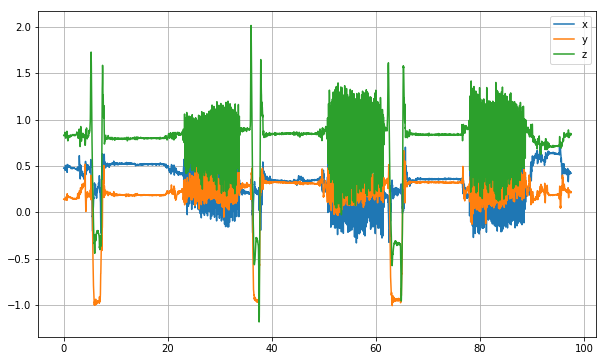

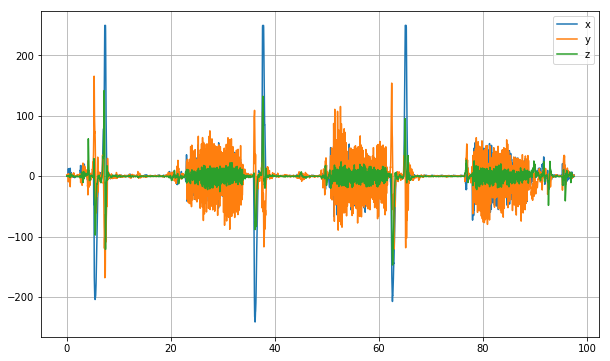

In [88]:
# View plot of data
figsize = (10, 6)


def plot(df, x, y, ax=None):
    """
    Plots the x and y selected from df
    
    Param:
        df: pd.DataFrame()
        x: str/int
        y: str[]/int[]
    """
    # Ensure y is iterable
    if type(y) != type([]):
        y = [y]
    
    if not ax:
        fig, ax = plt.subplots(1, figsize=figsize)
        
    for i in y:
        ax.plot(df[x], df[i])

    ax.legend()
    ax.grid()

for i in ['a', 'g']:
    plot(d[i]['df'], 'elapsed', ['x', 'y', 'z'])

# Using Scipy Rotation

In [89]:
# Creating rotation object

def vectorize(s, cols):
    """
    Returns a vectors with elements taken from columns sourced from columns in the series
    
    Param:
        s: pd.Series(): horizontal series, i.e. row
        indices: str[]/int[]
    Return:
        _: pd.Series()
    """
    # Ensure series is passed
    assert type(s) == type(pd.Series())

    # Ensure cols is a list
    if type(cols) != type([]):
        indices = [cols]

    filtered_cols = []

    # Ensure elements of list are integers (indices)
    for v in cols:
        try:
            s[v]

            filtered_cols.append(v)
        except:
            warn(
                '\'' + str(v) +
                '\' is not found in the series. The value will not be included in the vector.'
            )

    return [s[x] for x in filtered_cols]

# Set x, y and z to radians
for x in ['x', 'y', 'z']:
    d['g']['df']['r' + x] = d['g']['df'][x].apply(lambda y: math.radians(y))

# Vectorize x, y, and z in gyroscope
d['g']['df']['R'] = d['g']['df'].apply(lambda x: vectorize(x, ['rx', 'ry', 'rz']), axis=1)

# Create rotation object
# Change vector to rotation matrix object
d['g']['df']['R'] = d['g']['df']['R'].apply(lambda x: R.from_rotvec(x))

In [90]:
# Vectorize x, y, z in accelerometer
d['a']['df']['xyz'] = d['a']['df'].apply(lambda x: vectorize(x, ['x', 'y', 'z']), axis=1)

# Import rotation object
d['a']['df']['R'] = d['g']['df']['R']

# Apply rotation on accelerometer data sequentially
xyz = [np.array(d['a']['df']['xyz'][0])]

for i in range(d['g']['df'].shape[0] - 1):
    xyz.append(d['g']['df']['R'][i + 1].apply(xyz[-1], inverse=True))

# d['a']['df']['n_xyz'] = d['a']['df'].apply(lambda x : x['R'].apply(x['xyz'], inverse=True), axis=1)

for ix, v in enumerate(['x', 'y', 'z']):
    d['a']['df']['n' + v] = list(map(lambda x: x[ix], xyz))
    
# # Drop 'n_xyz'
# d['a']['df'] = d['a']['df'].drop(columns=['n_xyz'])

# xyz

In [91]:
d['a']['df']

,elapsed,x,y,z,xyz,R,"(nx, ny, nz)",nx,ny,nz
0,0.000,0.478,0.141,0.830,"[0.478, 0.141, 0.83]",(((<scipy.spatial.transform.rotation.Rotation ...,"[-0.8584166446864441, 0.38224104306964385, -0....",0.478000,0.141000,0.830000
1,0.019,0.480,0.140,0.833,"[0.48, 0.14, 0.833]",(((<scipy.spatial.transform.rotation.Rotation ...,"[-0.7379915846884955, 0.5185212087274818, -0.3...",0.441791,0.132770,0.851151
2,0.040,0.481,0.139,0.827,"[0.48100000000000004, 0.139, 0.8270000000000001]",(((<scipy.spatial.transform.rotation.Rotation ...,"[-0.9403186538418289, 0.21468507607268134, -0....",0.409608,0.128109,0.867799
3,0.059,0.481,0.142,0.828,"[0.48100000000000004, 0.142, 0.828]",(((<scipy.spatial.transform.rotation.Rotation ...,"[-0.7796007033098707, -0.032380881811675394, 0...",0.387219,0.125953,0.878329
4,0.079,0.478,0.142,0.829,"[0.478, 0.142, 0.8290000000000001]",(((<scipy.spatial.transform.rotation.Rotation ...,"[-0.4365774497783127, 0.08494506030278526, 0.8...",0.371916,0.126812,0.884795
...,...,...,...,...,...,...,...,...,...,...
4903,97.442,0.425,0.219,0.845,"[0.425, 0.21899999999999997, 0.845]",(((<scipy.spatial.transform.rotation.Rotation ...,"[-0.4123444466434947, 0.4664935460332034, 0.74...",0.240957,-0.115148,0.930562
4904,97.461,0.425,0.210,0.849,"[0.425, 0.21, 0.8490000000000001]",(((<scipy.spatial.transform.rotation.Rotation ...,"[-0.6339210494025984, 0.5302026214589719, 0.51...",0.226778,-0.103965,0.935429
4905,97.481,0.425,0.209,0.850,"[0.425, 0.209, 0.85]",(((<scipy.spatial.transform.rotation.Rotation ...,"[-0.5113457781576011, 0.8220827035275008, 0.09...",0.211829,-0.084261,0.940900
4906,97.500,0.425,0.213,0.847,"[0.425, 0.213, 0.847]",(((<scipy.spatial.transform.rotation.Rotation ...,"[-0.2811035950112463, 0.7494927093324593, -0.5...",0.192128,-0.053214,0.947375


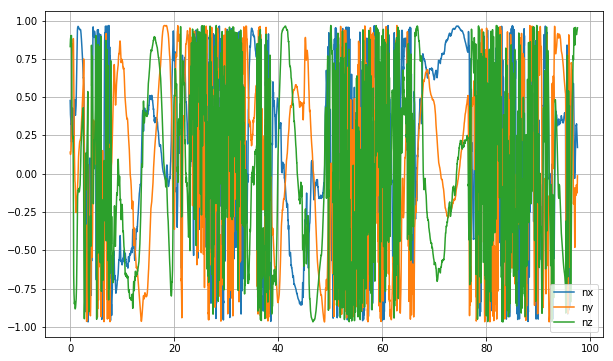

In [94]:
plot(d['a']['df'], 'elapsed', ['nx', 'ny', 'nz'])